In [1]:
%pip install -q langchain langchain_classic langchain_community langgraph langchain_chroma langchain-google-genai  youtube-transcript-api pytube pytubefix langchain-tavily dotenv

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain_chroma import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import YoutubeLoader
from dotenv import load_dotenv
from pytubefix import YouTube
from langchain_tavily import TavilyResearch
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence, Optional, List
from operator import add as add_messages
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import InMemorySaver
from datetime import datetime
import os
load_dotenv()


api_key = os.getenv('api_key')
tavily_key = os.getenv('tavily_key')

In [ ]:
llm = ChatGoogleGenerativeAI(
    api_key=api_key,
    model= "gemini-2.5-flash-lite"
)

embeddings = GoogleGenerativeAIEmbeddings(
    api_key=api_key,
    model="models/gemini-embedding-001"
)

In [ ]:
# url = input("Enter your video URL :")
url = "https://www.youtube.com/watch?v=LsI20I6M92c"

In [ ]:
loader = YoutubeLoader.from_youtube_url(
    url ,
    add_video_info = False
)

transcript = loader.load()
print(len(transcript))


1


In [ ]:
transcript[:50]

[Document(metadata={'source': 'LsI20I6M92c'}, page_content="Hi everyone and welcome to a new video. In this video, I'm going to discuss my last one week of coding journey where I purely used VIP coding tools or coding assistants to code. >> Sign in. >> I don't hate this. >> I did not write most lines of code or probably a single line of code. I was able to ship three products and we're going to talk through this journey of is this the future of coding? What does this lead to in terms of the jobs that might exist in the future? Is coding as a job going to become obsolete? and my learnings in this one week of journey. Will I continue to use wipe coding tools or is there a specific framework I'd use to use these frameworks to you know my boost my productivity without any further ado let's get into it the video is going to divided into six parts the first part I'm going to share the apps that I built in the last one week there are total of three apps one was a very simple contest platform 

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000 ,
    chunk_overlap = 200,
    add_start_index=True,
    separators=["\n\n", "\n", " ", ""]
)

docs = splitter.split_documents(transcript)
print(len(docs))

22


In [ ]:
docs[:20]

[Document(metadata={'source': 'LsI20I6M92c', 'start_index': 0}, page_content="Hi everyone and welcome to a new video. In this video, I'm going to discuss my last one week of coding journey where I purely used VIP coding tools or coding assistants to code. >> Sign in. >> I don't hate this. >> I did not write most lines of code or probably a single line of code. I was able to ship three products and we're going to talk through this journey of is this the future of coding? What does this lead to in terms of the jobs that might exist in the future? Is coding as a job going to become obsolete? and my learnings in this one week of journey. Will I continue to use wipe coding tools or is there a specific framework I'd use to use these frameworks to you know my boost my productivity without any further ado let's get into it the video is going to divided into six parts the first part I'm going to share the apps that I built in the last one week there are total of three apps one was a very simple

In [ ]:
yt = YouTube(url)
print(f"Title: {yt.title}")
print(f"Length: {yt.length} seconds")
print(f"Author: {yt.author}")
print(f"Thumbnail: {yt.thumbnail_url}")


Title: I Tried Vibe Coding for a Week - Here’s What Happened
Length: 815 seconds
Author: Harkirat Singh
Thumbnail: https://i.ytimg.com/vi/LsI20I6M92c/sddefault.jpg


In [ ]:
vector_store = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    collection_name="Youtube_Video"
)

In [ ]:
query = "Explain what is this video about?"

In [ ]:
results = vector_store.similarity_search_with_score(
    query,
    k = 10
)

threshold = 0.65


for i, (doc, score) in enumerate(results):
  if score >= threshold:
    print(f"\nResult #{i+1}")
    print("Score:", score)
    print("Source:", doc.metadata.get("source"))
    print("Content:", doc.page_content[:300])



Result #1
Score: 0.6755039691925049
Source: LsI20I6M92c
Content: Hi everyone and welcome to a new video. In this video, I'm going to discuss my last one week of coding journey where I purely used VIP coding tools or coding assistants to code. >> Sign in. >> I don't hate this. >> I did not write most lines of code or probably a single line of code. I was able to s

Result #2
Score: 0.6854989528656006
Source: LsI20I6M92c
Content: problem. video broadcasting tool come video recording tool come podcasting tool which is not very easy to build. It did require some level of you know human inter intervention from time to time. It doesn't work really well right now. If I show you what what it looks like um it's basically finessed t

Result #3
Score: 0.7204458117485046
Source: LsI20I6M92c
Content: link with a friend start recording. It'll record the pod for you in HD and you can finally you know see the recording in a in a workspace of yours. Eventually ed editor can come and you know get the l

In [ ]:
class AgentState(TypedDict):
  messages : Annotated[Sequence[BaseMessage], add_messages]
  question : str
  documents : list[str]
  search_needed : bool
  retries : int
  feedback: str
  is_good: bool


class JudgeEval(BaseModel):
  is_good: bool = Field(description="True if the answer is accurate and sufficient, False if it needs improvement")
  feedback: str = Field(description="Specific instructions on what to fix")

class Output(BaseModel):
  question : str = Field("User query, dont change the user query keep it as it is")
  answer : str = Field("Answer of the user query")
  follow_up : list[str] = Field("3-4 follow up questions")



In [ ]:
def router(state: AgentState) -> str:
    """
    Simple Router:
    - If Good -> Go to Structure/Finalize
    - If Bad -> Go to Search Tool (Once)
    """
    is_good = state.get("is_good", False)

    if is_good:
        print("--- DECISION: Answer is Good! -> Finalizing ---")
        return "GENERATE_ANSWER"
    else:
        print("--- DECISION: Answer needs work -> Searching Tavily (Fallback) ---")
        return "SEARCH_TAVILY"

In [ ]:
def retriver_tool(state : AgentState) -> AgentState:

  """
  This tool returns the relavent docsument from the vector db based on user input
  """

  query = state["messages"][-1].content



  results = vector_store.similarity_search_with_score(
    query,
    k = 10
  )
  found_docs = []
  threshold = 0.65
  for doc, score in results:
    if score >= threshold:
      found_docs.append(doc.page_content)
  print(found_docs)
  return {
      "question" : query,
      "documents" : found_docs
  }


def search_tavily(state : AgentState) -> AgentState:
  """
  This tool searches the tavily website for the answer to the user query
  """
  print("--- STEP 3: SEARCHING TAVILY (FALLBACK) ---")
  query = state["question"]
  tavily_research = TavilyResearch(
      tavily_api_key = tavily_key,
  )

  result = tavily_research.invoke(
      {
          "input" : query,
          "citation_format": "apa",
      }
  )

  print(results)

  content = str(results)
  return {
      "documents" : [content]
  }


In [ ]:
def agent(state : AgentState) -> AgentState:
  """
  This node drafts answers to the user query
  """
  query = state['question']
  docs = state['documents']

  context_docs = "\n\n".join(docs)
  now = datetime.now()

  print(f"Current Date and Time: {now}")

  prompt = f"""
  You are a helpful ai agent specialized in drafting answers based on user input.

  user query : {query}
  current datetime : {now}
  context : {context_docs} from the vector store based on the user query

  1. Generate an detailed answer to the user question with the context with examples.
  2. Answer only if the {query} and the {context_docs} are related. If they are not related just add a message saying that.
  """

  results = llm.invoke(
      prompt
  )


  return {
      "messages" : [results]
  }

In [ ]:

def judge(state: AgentState) -> AgentState:
  """
  This node critique the draft and provides suggestions
  """
  query = state['question']
  last_message = state['messages'][-1]
  draft_answer = last_message


  prompt =f"""
  You are a strict technical critic.
  user query : {query}
  draft answer : {draft_answer}
  Critique this answer.
    - If it fully answers the question using the context, say True.
    - If it is vague, missing info, or hallucinates, say False and explain why.

  """
  structured_llm = llm.with_structured_output(JudgeEval)

  results = structured_llm.invoke(
      prompt
  )

  return {
        "is_good": results.is_good,
        "feedback": results.feedback
    }


In [ ]:
def refelxion_agent(state : AgentState) -> AgentState:
  """
  This node drafts answers to the user query
  """
  query = state['question']
  feedback = state.get('feedback', "Please improve the answer.")
  retries = state.get('retries', 0)
  all_docs = "\n\n".join(state['documents'])





  prompt = f"""
    You are fixing a previous answer.
    User Question: {query}
    Critique: {feedback}

    UPDATED CONTEXT:
    {all_docs}

    Please write a new, accurate answer using the updated context.
    """

  results = llm.invoke(
      prompt
  )

  return {
      "messages" : [results],
      "retries": retries + 1
  }



In [ ]:
def generate_answer(state: AgentState) -> AgentState:
  print("--- 📝 GENERATING FINAL STRUCTURED OUTPUT ---")
  question = state["question"]
  last_message = state["messages"][-1]
  draft_answer = last_message.content

  prompt = f"""
  You are a helpful assistant.
  User Query: {question}
  Draft Answer: {draft_answer}

  Restructure the Draft Answer to fit the schema.
  """

  structured_llm = llm.with_structured_output(Output)
  pydantic_result = structured_llm.invoke(prompt)

  # Return JSON String
  return {
    "messages" : [AIMessage(content=pydantic_result.model_dump_json(indent=2))]
  }

In [ ]:
def final_agent(state: AgentState) -> AgentState:
    """
    This node drafts the final answer after the fallback search tool has run.
    It is identical to the main agent but sits in a different place in the graph.
    """
    print("--- 📝 DRAFTING FINAL ANSWER (AFTER SEARCH) ---")

    return agent(state)

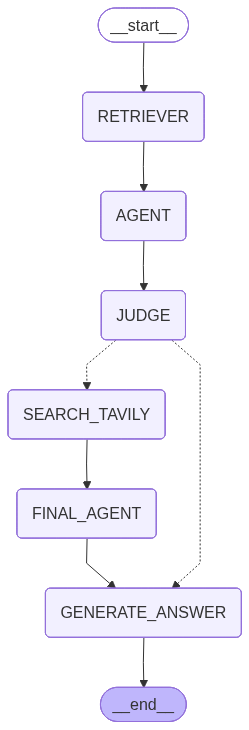

In [ ]:
workflow = StateGraph(AgentState)


workflow.add_node("RETRIEVER", retriver_tool)
workflow.add_node("AGENT", agent)
workflow.add_node("JUDGE", judge)
workflow.add_node("SEARCH_TAVILY", search_tavily)
workflow.add_node("FINAL_AGENT", final_agent)
workflow.add_node("GENERATE_ANSWER", generate_answer)

# Add Edges (Linear Flow)
workflow.add_edge(START, "RETRIEVER")
workflow.add_edge("RETRIEVER", "AGENT")
workflow.add_edge("AGENT", "JUDGE")


workflow.add_conditional_edges(
    "JUDGE",
    router,
    {
        "GENERATE_ANSWER": "GENERATE_ANSWER", # If Good
        "SEARCH_TAVILY": "SEARCH_TAVILY"      # If Bad
    }
)

# The "Bad" Path Flow
workflow.add_edge("SEARCH_TAVILY", "FINAL_AGENT")  # Get content -> Draft answer
workflow.add_edge("FINAL_AGENT", "GENERATE_ANSWER") # Draft -> Structure


workflow.add_edge("GENERATE_ANSWER", END)


app = workflow.compile(checkpointer=InMemorySaver())

from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization skipped (requires mermaid support).")

In [ ]:
print("=================YouTube Rag ChatBot=================")
while True:
    query = input("Enter : ")
    if query.lower() in ["quit", "exit"]: break

    inputs = {"messages": [HumanMessage(content=query)]}
    config = {"configurable": {"thread_id": "3"}}

    print(f"🚀 Starting Agent with input: {query}\n")

    for output in app.stream(inputs, config=config):
        for node_name, state_update in output.items():
            print(f"\n--- 🔄 Calling Node: {node_name} ---")

            if node_name == "JUDGE":
                print(f"Decision: {'✅ Good' if state_update.get('is_good') else '❌ Needs Improvement'}")

            elif node_name == "GENERATE_ANSWER":
                # --- FIX: Print .content directly ---
                msgs = state_update.get('messages')
                if msgs:
                    print(f"\n📝 Final Answer:\n{msgs[-1].content}")

=================YouTube Rag ChatBot=================
Enter : explain me about vibe coding
🚀 Starting Agent with input: explain me about vibe coding

["I would wipe code. A lot of times, companies force you to wipe code to be productive, which is fine. >> You like crazy than a year. I think it makes sense for me to wipe code. When I say wipe code, I mean I not even look at the code because whenever I have to look at the code, I'll probably understand it. But if there's a language I'm not super comfortable in. Let's say I want to learn C today. I would definitely not wipe code. I would struggle through the process because you know the learning that you have in that one year and then you using V coding tools is probably you know a more productive path for your career compared to you using V coding you know from the get- go. It doesn't matter how good AI coding tools become. If your brain is not being developed in the process, it's probably going to hurt you in the long run. But you know 